In [2]:
import numpy as np
import pandas as pd
import warnings # eventually I can log warnings in a different file (leaving it to the further consideration)

# =============================================================================
#                           HELPER FUNCTIONS
# =============================================================================

"""
NUMERIC SAFETY CONSTANTS (EXPLAINED)

These magic numbers are kept inline for simplicity but explained here:
 - 1e-4  : epsilon to check if WACC is "close enough" to growth rate (≈ 1 basis point)
 - 1e-12 : threshold to treat a value as numerically zero (e.g., ROIC)
 - 1e-9  : minimum total capital to avoid divide-by-zero in WACC
 - 9999.99 : fallback value for levered beta when equity = 0 (simulates extreme leverage)

"""
def safe_linear_converge(
    start_val: float,
    end_val: float,
    total_years: int,
    converge_start_year: int
) -> pd.Series:
    """
    Linearly interpolates a value over time, starting from a constant period,
    and converging to a final value across a series of years.

    Used to model gradual transitions of key inputs in a DCF (e.g., margins, taxes, betas).

    Returns: pd.Series of floats (length = total_years), with values:
        - constant at `start_val` before convergence begins,
        - linearly converging to `end_val` over remaining years.

    Example:
        - Input: safe_linear_converge(0.25, 0.15, 10, 4)
        - Returns: [0.25, 0.25, 0.25, 0.25, 0.225, 0.2, 0.175, 0.15, 0.15, 0.15]

    Edge Cases:
        - If converge_start_year >= total_years: the entire series is just start_val.
        - If total_years <= 0: returns an empty Series.

    Financial interpretation:
        - Real companies don’t instantly change their financials. Most transitions are gradual;
        - This gives the model realism and flexibility to handle different time horizons and convergence speeds;
        - It helps avoid sharp “cliffs” or “jumps” in assumptions.
    """
    if total_years <= 0:
        return pd.Series([], dtype=float) # return an empty series.

    # If converge starts at or after final year, no actual interpolation (return a flat series at start_val)
    if converge_start_year >= total_years:
        return pd.Series([start_val]*total_years, dtype=float)

    # Phase 1: remain at start_val until just before converge_start_year
    phase1_len = max(0, converge_start_year - 1)  # years of flat
    phase1 = [start_val] * phase1_len

    # Phase 2: linearly converge for the remaining years
    phase2_len = total_years - phase1_len
    phase2_vals = np.linspace(start_val, end_val, phase2_len)

    return pd.Series(np.concatenate([phase1, phase2_vals]), dtype=float)


def project_three_phase_growth(
    g1_start, g1_end, len1,
    g2_start, g2_end, len2,
    g3_start, g3_end, len3
) -> pd.Series:
    """
    Creates a combined growth rate series from three consecutive linear phases.

    This function is used to project a series of revenue growth rates across 3 distinct phases of a company’s life cycle:
        - Phase 1: High growth
        - Phase 2: Transition
        - Phase 3: Stable growth

    Example:
    project_three_phase_growth(
       0.20, 0.15, 5,  # Phase 1: 20% → 15% over 5 years
       0.15, 0.07, 3,  # Phase 2: 15% → 7% over 3 years
       0.07, 0.025, 5  # Phase 3: 7% → 2.5% over 5 years
    )

    Returns a Series of 13 values, gradually declining from 20% → 2.5%.

    Financial interpretation:
       - Phase 1: Fast early growth (New market, strong product);
       - Phase 2: Deceleration / saturation starts (More competition, market slows);
       - Phase 3: Stabilizes at economy-level growth rate (Steady-state, mature business).

    Why use this method instead of one flat growth rate?:
       - Because most real businesses do not grow at a constant rate forever;
       - DCF needs to reflect this trajectory to avoid overvaluing or undervaluing the firm.
    """
    series1 = np.linspace(g1_start, g1_end, len1) if len1 > 0 else np.array([])
    series2 = np.linspace(g2_start, g2_end, len2) if len2 > 0 else np.array([])
    series3 = np.linspace(g3_start, g3_end, len3) if len3 > 0 else np.array([])

    return pd.Series(np.concatenate([series1, series2, series3]), dtype=float)


def project_revenue(
    base_revenue: float,
    growth_series: pd.Series
) -> pd.Series:
    """
    Computes projected revenue over time using a compound growth model (the revenue growth series).

    Parameters:
       - base_revenue : float
            The initial revenue value (e.g., last fiscal year's revenue).
            This acts as the base for all future revenue projections.
            Must be non-negative; a warning is raised if negative.
       - growth_series : pd.Series
            A time series of yearly growth rates (as decimals, not percentages).
            Each element represents the expected revenue growth for that year.
            The length of this series determines the projection horizon.
       - Returns: pd.Series
            A series of projected absolute revenue values for each year.
            The first year is calculated as base_revenue × (1 + growth[0]),
            and each subsequent year compounds on the previous year's value.
           
    Warnings:
       - If base revenue is negative, a warning is raised.
       - If the growth series is empty, returns an empty Series.

    Example:
       If:
       - base_revenue = 1000;
       - growth_series = [0.10, 0.08, 0.06];
       Then:
       - Year 1: 1000 × (1 + 0.10) = 1100.0;
       - Year 2: 1100 × (1 + 0.08) = 1188.0;
       - Year 3: 1188 × (1 + 0.06) = 1259.28.
       So:
       - revenue_series = [1100.0, 1188.0, 1259.28];
       
   Financial interpretation:
      - This function answers: “If the company grows at the rates I assumed, what will its revenues be in each future year?”;
      - It is the foundation of your DCF model — everything is based on revenue.

   Why revenue should not be negative?:
      - Revenue (also called "sales" or "top line") represents the gross inflow of economic benefits from a company's core operations (e.g., selling products or services);
      - By definition it is positive (or zero);
      - If a company earns less than zero, we don't state it has negative revenue — we state it has revenue with losses (via negative profit, not revenue).

    """
    if base_revenue < 0:
        warnings.warn("Base revenue is negative, which is unusual.")
    n = len(growth_series)
    revenue = pd.Series(index=range(n), dtype=float)
    if n == 0:
        return revenue

    revenue[0] = base_revenue * (1 + growth_series.iloc[0])
    for i in range(1, n):
        revenue[i] = revenue[i-1] * (1 + growth_series.iloc[i])
    return revenue


def compute_dynamic_levered_beta_series(
    unlevered_beta_start: float,
    unlevered_beta_end: float,
    total_years: int,
    converge_start_year: int,
    tax_rate: float,
    equity_series: pd.Series,
    debt_series: pd.Series
) -> pd.Series:
    """
    Computes a time series of levered beta values of over a multi-year horizon, adjusting for:
       - A changing capital structure (Debt and Equity);
       - A gradually evolving unlevered beta, and;
       - The impact of taxes on leverage.

    Formula:
        Levered Beta = Unlevered Beta × [1 + (1 - Tax Rate) × (Debt / Equity)]

    Parameters:
       - unlevered_beta_start : float
            The starting value for the unlevered beta in year 1.
            Represents business risk without financial leverage;
       - unlevered_beta_end : float
            The final value that the unlevered beta will converge to
            by the end of the projection period.
       - total_years : int
            Number of years in the projection horizon.
       - converge_start_year : int
            The year in which convergence from unlevered_beta_start to unlevered_beta_end begins.
            Prior to this year, the unlevered beta remains constant.;
       - tax_rate : float
            The effective tax rate used to adjust for the tax shield on interest in the levered beta formula.
            Must be a decimal (e.g., 0.25 for 25%).
       - converge_start_year : int
            The year in which convergence from unlevered_beta_start to unlevered_beta_end begins.
            Prior to this year, the unlevered beta remains constant.;
       - equity_series : pd.Series
            A series of equity values for each projected year.
            Used in the denominator of the debt/equity ratio.
       - debt_series : pd.Series
            A series of debt values for each projected year.
            Used in the numerator of the debt/equity ratio.      
       - Returns 
            pd.Series time series of levered beta values over the forecast horizon.

    Edge cases: 
    - If equity goes to zero, we would get divide-by-zero or an infinite beta;
    - If equity = 0 in any year -> issues warning and assigns high fallback beta (e.g. 9999) to simulate high leverage (extremely high risk).
    - Handles convergence and dynamic capital structure in one place.
    - prof. Damodaran states that extremely high leverage causes beta to rise without bound.
    - the numeric fallback approximates that infinite-beta scenario in a controlled, defensible way

    Usage context:
    Levered beta is used to calculate the cost of equity via the CAPM formula:
        Cost of Equity = Risk-Free Rate + Beta × Equity Risk Premium
    
    """
    unlev_beta_series = safe_linear_converge(
        unlevered_beta_start, unlevered_beta_end,
        total_years, converge_start_year
    )
    levered_betas = []
    for i in range(total_years):
        d_over_e = 0.0
        if equity_series[i] == 0:
            warnings.warn(f"Equity is zero in year {i+1}, cannot compute D/E.")
            d_over_e = 9999.99  # fallback extreme leverage
        else:
            d_over_e = debt_series[i] / equity_series[i]

        levered_betas.append(unlev_beta_series.iloc[i] * (1 + (1 - tax_rate) * d_over_e))

    return pd.Series(levered_betas)


def build_static_series(
    val: float,
    length: int
) -> pd.Series:
    """
    Creates a constant time series of a specified value.

    Used to simulate a static (fixed) cost of capital, equity, or debt value
    over the forecast period when dynamic projections are not needed.

    Returns pd.Series of length `length`, all values set to `val`.

    Usage example: build_static_series(1000, 5) → [1000, 1000, 1000, 1000, 1000]

    Financial interpretation:
    - Not every variable in a forecast changes:
       - A company may hold debt constant;
       - We may want to assume flat tax rate;
       - If our model isn’t meant to project dynamic debt/equity, this keeps things simple and clean.
    """
    return pd.Series([val]*length, dtype=float)


def compute_wacc_series(
    cost_of_equity: pd.Series,
    pre_tax_cost_of_debt: pd.Series,
    tax_rate: float,
    equity_series: pd.Series,
    debt_series: pd.Series
) -> pd.Series:
    """
    The WACC reflects the blended cost of financing a firm using both equity and debt,
    adjusted for the tax shield on interest expense. It is used as the discount rate
    for free cash flows in DCF valuation.

    Formula:
        WACC = (E / (E + D)) × Re + (D / (E + D)) × Rd × (1 - Tax Rate)

    Where:
        E = Equity
        D = Debt
        Re = Cost of Equity
        Rd = Cost of Debt (pre-tax)

    Parameters:
    cost_of_equity : pd.Series
        Series of yearly cost of equity (Re).

    pre_tax_cost_of_debt : pd.Series
        Series of yearly cost of debt before taxes (Rd).

    tax_rate : float
        Effective tax rate used to adjust cost of debt. Must be expressed as a decimal (e.g., 0.25 for 25%).

    equity_series : pd.Series
        Series of equity values for each projected year (E).

    debt_series : pd.Series
        Series of debt values for each projected year (D).

    Returns pd.Series 
       a time series of WACC values (one per year), representing the firm's discount rate.

    Warnings:
    - If total capital (E + D) <= 1e-9 (near 0) -> fallback: uses cost_of_equity directly as WACC.
    - the cost of equity remains a defined number — it reflects the opportunity cost of capital from a shareholder’s perspectivel
    - From the Modigliani-Miller framework and prof. Damodaran’s statements:
       - If debt = 0 → WACC = cost of equity;
       - If debt ≈ 0 and equity is extremely small → WACC ≈ cost of equity;
       - If total capital = 0 → fallback to cost of equity as a proxy for opportunity cost.

    Usage context:
    WACC is used to discount FCFF and compute the present value of cash flows.
    It's also critical for terminal value calculation.

    Financial interpretation:
    - WACC reflects:
     - Risk of the business (via beta);
     - Capital structure choices (debt vs. equity);
     - Tax shields on interest (which lower WACC)
     - Lower WACC -> higher valuation;
     - Higher WACC -> more discounting -> lower valuation
    """
    wacc_vals = []
    n = len(cost_of_equity)
    for i in range(n):
        e = equity_series[i]
        d = debt_series[i]
        total_cap = e + d
        if total_cap <= 1e-9: # prevent divide-by-zero
            warnings.warn(f"Total capital near zero in year {i+1}, WACC is ill-defined.")
            wacc_vals.append(cost_of_equity[i])  # fallback
            continue

        e_weight = e / total_cap
        d_weight = d / total_cap
        after_tax_cost_debt = pre_tax_cost_of_debt[i] * (1 - tax_rate)
        wacc_vals.append(e_weight * cost_of_equity[i] + d_weight * after_tax_cost_debt)

    return pd.Series(wacc_vals)


def compute_reinvestment(
    revenue_series: pd.Series,
    sales_to_capital_series: pd.Series,
    base_revenue: float,
    asset_liquidation_factor_for_neg_growth: float
) -> pd.Series:
    """
    Computes the reinvestment required each year to support revenue growth,
    based on the firm's sales-to-capital ratio. If revenue declines, a portion
    of previously invested capital is assumed to be recoverable.

    What Is Capital Recovery?

    Capital recovery means when a business shrinks (revenues fall), 
    it can often pull money out of the business — by liquidating or reducing the assets it no longer needs.

    Formula:
        Reinvestment = ΔRevenue / (Sales-to-Capital Ratio)

    If ΔRevenue < 0 (i.e., revenue declines), a portion of previously invested
    capital is recovered (released) based on the `asset_liquidation_factor`:
        Reinvestment = ΔRevenue x liquidation factor
    
    Parameters:
       - revenue_series : pd.Series
            Projected revenues for each forecast year (starting from Year 1).
       - sales_to_capital_series : pd.Series
            Sales-to-capital ratio for each year. Represents the amount of revenue
            generated per dollar of capital invested. The total capital invested in operations — includes net fixed assets and non-cash working capital. 
            It represents the base on which future returns are generated.
            Formula for invested capital:
            Invested capital = Net PPE + Non-cash Working Capital
            
            What is Net PPE?
            The value of physical assets (Property, Plant & Equipment) the company still owns and uses in operations (excluding assets already depreciated or no longer in use).
            In a DCF, Net PPE is a proxy for long-term productive capital.
            Formula for net PPE = Gross PPE - Accumulated Depreciation
  
       -  base_revenue : float
            The revenue from Year 0 (preceding the forecast), used to compute the first ΔRevenue.
       - asset_liquidation_factor_for_neg_growth : float
            Factor (between 0.0 and 1.0) that determines what proportion of capital is recovered
            when revenue declines. For example, 0.5 means 50% of capital is recovered.
            The above capital is the operating assets the company invested in (e.g., fixed assets, working capital) 
            to support past growth in revenue (it does not include: Excess cash, Financial investments, Goodwill).

       - Returns pd.Series 
            A time series representing the reinvestment (or capital recovery if negative)
            required in each year to support the projected revenue growth.
  
    Edges cases:
    - If sales-to-capital ≤ 0 -> warning; reinvestment may be miscalculated.
    - Uses `base_revenue` to compute year-over-year changes.

    Example:
     - Revenue goes from $1000 → $1100 → $1200 → $1170;
     - Sales-to-capital = 2.0 (i.e., $2 revenue per $1 of invested capital)
     - Then:
        ΔRevenue_1 = 100 -> Reinvestment = 100/2=50
        ΔRevenue_2 = -30 -> Reinvestment = −30/2 x 0.5=−7.5

    Financial interpretation: 
    - Reinvestment drives the free cash flow to firm (FCFF), since: FCFF = After-Tax EBIT – Reinvestment;
      - Higher EBIT → more value;
      - Lower taxes → more value;
      - Lower reinvestment → more value (you retain more cash, that is releases cash from the balance sheet.);
    - According to prof. Damodaran's a shrinking firm does not need to reinvest, and in fact may generate cash from divesting assets. 
      Ignoring this would understate cash flows and understate value.
    - This function connects the growth of your company to the capital investment required to support it;
      - Higher growth -> more reinvestment;
      - Lower STC ratio -> more capital needed per $ of growth;
      - Negative growth -> we get to recover some capital.
    """
    n = len(revenue_series)
    if n == 0:
        return pd.Series([], dtype=float)

    # Combine base + forecast to measure changes
    combined = pd.concat([pd.Series([base_revenue]), revenue_series], ignore_index=True)
    delta_rev = combined.diff().dropna().reset_index(drop=True) # we need year-over-year changes in revenue

    reinv = delta_rev / sales_to_capital_series
    reinv_adj = np.where(
        reinv < 0,
        reinv * asset_liquidation_factor_for_neg_growth,
        reinv
    )
    return pd.Series(reinv_adj, dtype=float)


def build_discount_factors(
    wacc_series: pd.Series,
    mid_year_convention: bool
) -> pd.Series:
    """
    Builds a time series of discount factors for each forecast year based on the given 
    cost of capital, with optional mid-year convention.

    These discount factors are used to convert projected future free cash flows (FCFF)
    into present value. The mid-year convention assumes that cash flows are received
    evenly throughout each year, and therefore on average arrive at mid-year rather than
    year-end.

    Formula:
        If mid_year_convention=False => discount factor year i is 1/(1+WACC)^i
        If mid_year_convention=True  => discount factor year i is 1/(1+WACC)^(i - 0.5) to reflect cash flows arriving mid-year

   Parameters:
       - wacc_series : pd.Series
             A pandas Series of annual discount rates (WACC), expressed as decimals (e.g., 0.09 for 9%),
             where each element corresponds to the discount rate for a specific forecast year.
             The index should reflect the forecast year (e.g., 1, 2, 3, ...).
       - mid_year_convention : bool
              If True, applies mid-year discounting by using (t - 0.5) in the exponent, assuming
              cash flows are received evenly throughout each year. If False, uses standard end-of-year
              discounting with exponent t.

       - Returns pd.Series 
               A Series of discount factors corresponding to each forecast year. These can be directly 
               multiplied by forecasted FCFFs to compute present values (PV).

    Example:
    If WACC = 10%, Year 1:
        - No mid-year: DF = 1 / (1.1)^1 ≈ 0.909
        - With mid-year: DF = 1 / (1.1)^0.5 ≈ 0.953

    Why mid-year convention?
        - Companies earn cash flow gradually, not in one lump sum on December 31st;
        - The mid-year convention assumes cash is received evenly through the year → on average, around June 30th;
        - This gives you the present value multiplier for cash flows received during each year.
        - The above leads to increas of the present value slightly — typically by 2–3%, depending on the cost of capital.
    
    """
    dfs = []
    for i in range(len(wacc_series)):
        if mid_year_convention:
            exponent = i + 0.5 # Python uses 0-based indexing, but finance assumes Year 1 is first year
        else:
            exponent = i + 1
        df = 1.0 / ((1 + wacc_series[i]) ** exponent)
        dfs.append(df)
    return pd.Series(dfs, dtype=float)


def compute_terminal_value(
    last_after_tax_ebit: float,
    final_wacc: float,
    stable_growth_rate: float,
    additional_return_on_capital: float = 0.0,
    allow_wacc_less_than_g: bool = False,     # NEW (I will leave it, it works)
    epsilon: float = 1e-4                     # NEW (≈ 1 bp)
) -> (float, float):
    """
    Computes the terminal value (TV) of a firm using the Gordon growth model 
    applied to Free Cash Flow to the Firm (FCFF), along with the implied 
    stable reinvestment rate.

    The terminal value estimates the present value of all future FCFF 
    beyond the explicit forecast period, assuming perpetual growth at 
    a stable rate. This component often represents over 50% of total 
    firm value in a DCF and must be modeled with caution.

    Formula:
        Terminal Value = FCFF_terminal / (WACC - g)
        where FCFF_terminal = After-Tax EBIT × (1 - Reinvestment Rate)
              Reinvestment Rate = g / (ROIC), with ROIC = WACC + Excess Return on Capital

    Parameters:
    - last_after_tax_ebit : float
         Final year's EBIT after tax (i.e., EBIT × (1 - tax rate)).
         
    - final_wacc : float
         Weighted Average Cost of Capital in the terminal year.
         Used both to discount terminal FCFF and as proxy for ROIC.

    - stable_growth_rate : float
         Long-term perpetual growth rate for the firm beyond forecast period.
         Should generally not exceed the nominal GDP growth rate (~2–3%).

    - additional_return_on_capital : float, default=0.0
        Assumed premium over WACC that the firm can continue to earn on new capital.
        If > 0, implies the firm maintains a competitive advantage into perpetuity.
        Prof. Damodaran often assumes ROIC will converge to its WACC in perpetuity, unless justified otherwise -
        In the long run, competitive forces drive returns toward WACC.

    allow_wacc_less_than_g : bool, default=False
        If True, permits modeling scenarios where WACC < g (rare and risky).
        If False (default), will raise ValueError if WACC < g, as this implies
        an infinite or negative terminal value.

    epsilon : float, default=1e-4
        Tolerance for checking if WACC is "effectively equal" to g.
        Prevents division by near-zero in the denominator.

    Returns: 
    - terminal_value: float
         The present value of all FCFF beyond the forecast period.
    - stable_reinvestment_rate: float
         The implied reinvestment rate in perpetuity to support stable growth,
         calculated as g / ROIC when g > 0 and ROIC > 0. 
         It helps to report what % of EBIT must be reinvested to support stable growth.

    Edge cases:
    - If WACC ≈ g (within epsilon), raise ValueError to prevent explosion (may lead to extremely high terminal value — model safeguards are applied).
    - If WACC < g and not explicitly allowed, raise ValueError.
    - If ROIC is very small - near 0 - (<= 1e-12), reinvestment rate is forced to zero.

    Financial Interpretation:
        - Terminal value assumes firm enters maturity;
        - No high growth, no big capital expenditures;
        - ROIC stabilizes, margins stabilize, firm reinvests only what is needed to maintain stable growth;
        - The reinvestment rate ensures that long-term growth is supported by sufficient capital;
        - This model forces the user to be conservative unless he has strong justification.
    """
    # Compute stable ROIC
    stable_roic = final_wacc + additional_return_on_capital
    if stable_roic <= 1e-12: # treat as near-zero to avoid divide-by-zero
        warnings.warn("Stable ROIC ~ zero or negative; forcing reinvestment rate = 0.")
        stable_reinv_rate = 0 # If ROIC is ~0, the firm cannot grow by reinvesting — so we force reinvestment to 0.
    else:
        if stable_growth_rate > 0:
            stable_reinv_rate = stable_growth_rate / stable_roic
        else:
            # If stable growth <= 0 => no new reinvestment
            stable_reinv_rate = 0

    fcff_stable = last_after_tax_ebit * (1 - stable_reinv_rate)

    denominator = final_wacc - stable_growth_rate

    # Guard 1 – WACC ≈ g
    if abs(denominator) < epsilon: # WACC and g are too close
        raise ValueError(
             f"WACC ({final_wacc:.4%}) is within {epsilon:.1e} of g ({stable_growth_rate:.4%})."
            )
    # Guard 2 – WACC < g, value explodes, unless it's for a rare case (e.g., very high-growth firms).    
    if denominator < 0 and not allow_wacc_less_than_g:
        raise ValueError(
            f"WACC ({final_wacc:.4%}) is < g ({stable_growth_rate:.4%}). "
            "Set allow_wacc_less_than_g=True if you really mean it."
        )
    if denominator < 0:
        warnings.warn("WACC < g — terminal value will be negative.")

    terminal_val = fcff_stable / denominator
        
    return terminal_val, stable_reinv_rate


# =============================================================================
#                    MAIN MULTI-PHASE DCF FUNCTION
# =============================================================================

def run_multi_phase_dcf(
    # -- Growth & Duration --
    revenue_base: float,
    # cycle 1
    revenue_growth_rate_cycle1_begin: float,
    revenue_growth_rate_cycle1_end: float,
    length_of_cycle1: int,
    # cycle 2
    revenue_growth_rate_cycle2_begin: float,
    revenue_growth_rate_cycle2_end: float,
    length_of_cycle2: int,
    # cycle 3
    revenue_growth_rate_cycle3_begin: float,
    revenue_growth_rate_cycle3_end: float,
    length_of_cycle3: int,

    # -- Operating Margin, Sales-to-Capital, Tax Rates --
    initial_operating_margin: float,
    terminal_operating_margin: float,
    operating_margin_convergence_start_year: int,

    initial_sales_to_capital_ratio: float,
    terminal_sales_to_capital_ratio: float,
    sales_to_capital_convergence_start_year: int,

    initial_effective_tax_rate: float,
    terminal_tax_rate: float,
    tax_rate_convergence_start_year: int,

    # -- Cost of Capital: Beta, Debt, etc. (static or dynamic) --
    risk_free_rate: float,
    equity_risk_premium: float,
    initial_unlevered_beta: float,
    unlevered_beta_terminal: float,
    beta_convergence_start_year: int,

    initial_pretax_cost_of_debt: float,
    terminal_pretax_cost_of_debt: float,
    debt_cost_convergence_start_year: int,

    # Capital Structure (optionally dynamic)
    initial_equity_value: float,
    initial_debt_value: float,
    # if we want dynamic, pass a function or list => default is static
    equity_value_projection=None,
    debt_value_projection=None,

    # -- Terminal Value additional inputs --
    additional_return_on_capital_in_perpetuity: float = 0.0,
    allow_wacc_less_than_g: bool = False,   # NEW – bubbles up to TV helper
    # -- Misc toggles & config --
    mid_year_convention: bool = False,
    current_invested_capital='implicit',
    asset_liquidation_factor_for_neg_growth: float = 0.0,
    cash_and_non_operating_assets: float = 0.0
):
    """
    Perform a comprehensive multi-phase Discounted Cash Flow (DCF) valuation
    with dynamic inputs, transitioning business assumptions, and rigorous 
    treatment of reinvestment and capital costs.

    This function implements a 3-stage DCF model consistent with real-world
    corporate valuation best practices.
    It supports dynamic capital structure, mid-year discounting, reinvestment 
    recovery logic, and long-term terminal value modeling.

    This function models company cash flows in three stages:
        1. Phase 1: High growth (early stage)
           - Revenue growth is elevated due to market opportunity or innovation;
           - Margins may be improving, reflecting operating leverage.
        2. Phase 2: Transition phase (competition, saturation);
           - Growth decelerates as the firm matures;
           - Operating assumptions converge to steady-state levels.
        3. Phase 3: Stable phase (mature business):
           - Revenue growth converges to long-term GDP-like rates;
           - Margins, capital structure, and reinvestment stabilize;
           - Terminal value reflects cash flows beyond this horizon.

    Key financial elements:
      - Revenue Projection: Modeled using three distinct growth cycles;
      - Operating Margins: Gradually converge to a terminal level;
      - Taxes: Evolve over time using effective tax rates;
      - Reinvestment Needs: Based on sales-to-capital ratio. Supports capital recovery if growth is negative;
      - Capital Structure: Allows static or dynamic modeling of equity and debt;
      - Cost of Capital:
        - Cost of Equity via CAPM with levered beta;
        - Cost of Debt evolves over time;
        - WACC computed annually from capital structure.

    Terminal value logic:
      - Terminal Value computed using the Gordon Growth Model:
        - TV = FCFF_terminal / (WACC - g);
      - Implied Reinvestment Rate = g / ROIC (ROIC = WACC + excess return);
      - Built-in safeguards against explosive valuation when WACC ≈ g or WACC < g.

    Returns a dictionary containing:
      - 'valuation': pd.DataFrame
         Year-by-year projections of key financial drivers:
         Revenue, Growth, EBIT, Reinvestment, FCFF, Cost of Capital, WACC,
         Discount Factors, Terminal Value, Present Value.
         
      - 'value_of_operating_assets': float
         Present value of forecasted FCFF including terminal value.
         
      - 'cash_and_non_operating_assets': float
         Add-on value for excess cash, marketable securities, or non-core assets.
         
      - 'firm_value': float
         Enterprise value (value of core business) + non-operating assets.
         
      - 'final_debt_subtracted': float
         Final-year debt subtracted to reach equity value.
      
      - 'equity_value': float
         Equity value of the firm (firm value – debt).
      
      - 'valuation_bridge': dict
         Step-by-step bridge from enterprise value to equity value.

    The 'valuation' DataFrame includes:
        - Revenue, Growth Rates
        - Margins, EBIT, Taxes
        - Reinvestment and FCFF
        - Levered Beta, Cost of Capital, WACC
        - Discount Factors, Present Value of FCFF
        - Terminal Value and Stable Reinvestment Rate
        - Equity and Debt Projections

    Model assumptions:
        - Mid-year convention moves discounting to the middle of the year, increasing present values.
        - If revenue shrinks, reinvestment may become negative (asset recovery).
        - The terminal value is sensitive to assumptions about WACC and growth — model these carefully.
        - All rates and ratios must be in decimal format (e.g., 0.15 for 15%);
        - All monetary values must be in consistent currency units (e.g., USD millions);

    Note:
    This function is designed to take intuitive, point-in-time scalar inputs (e.g., initial tax rate,
    terminal margin, revenue growth start/end) rather than full year-by-year time series. Internally,
    the function constructs all required `pd.Series` projections using helper functions such as:

       - `safe_linear_converge(...)` — for margins, tax rates, beta, STC, and cost of debt;
       - `project_three_phase_growth(...)` — for multi-phase revenue growth;
       - `project_revenue(...)` — to compute compounded revenue from a base year;
       - `build_static_series(...)` — for static capital structure if dynamic projections are not provided.

    This design allows users to provide clean and readable inputs, while the model handles 
    interpolation and time-series construction automatically behind the scenes. The only inputs 
    that may be passed as functions or lists are the `equity_value_projection` and 
   `debt_value_projection`, which support dynamic or static capital structure modeling.
    
    """
    # =================== 0. Basic checks & setup ===================
    total_years = length_of_cycle1 + length_of_cycle2 + length_of_cycle3
    if total_years <= 0:
        warnings.warn("Total forecast length is zero or negative. Returning empty results.")
        return {
            'valuation': pd.DataFrame(),  # Returns a dictionary with empty valuation and zeros.
            'value_of_operating_assets': 0.0,
            'firm_value': 0.0,
            'equity_value': 0.0
        }

    # =================== 1. Growth series & Revenue ===================
    growth_series = project_three_phase_growth(
        revenue_growth_rate_cycle1_begin, revenue_growth_rate_cycle1_end, length_of_cycle1,
        revenue_growth_rate_cycle2_begin, revenue_growth_rate_cycle2_end, length_of_cycle2,
        revenue_growth_rate_cycle3_begin, revenue_growth_rate_cycle3_end, length_of_cycle3
    )

    revenue_series = project_revenue(revenue_base, growth_series)
    if (revenue_series < 0).any(): #  checks if any values are True (warn on negative or illogical values)
        warnings.warn("Revenue has gone negative in some years. Check assumptions.")

    # =================== 2. Operating Margins, Tax, STC ===================
    margin_series = safe_linear_converge(
        initial_operating_margin,
        terminal_operating_margin,
        total_years,
        operating_margin_convergence_start_year
    )
    if (margin_series < 0).any():   
        warnings.warn("Operating margin is negative in some forecast years.")

    tax_series = safe_linear_converge(
        initial_effective_tax_rate,
        terminal_tax_rate,
        total_years,
        tax_rate_convergence_start_year
    )
    if (tax_series < 0).any() or (tax_series > 1).any():
        warnings.warn("Tax rate < 0% or > 100% in some years. Check assumptions.")

    stc_series = safe_linear_converge(
        initial_sales_to_capital_ratio,
        terminal_sales_to_capital_ratio,
        total_years,
        sales_to_capital_convergence_start_year
    )
    if (stc_series <= 0).any():
        warnings.warn("Sales-to-capital ratio <= 0 in some years. Reinvestment logic may break.")

    # =================== 3. Capital Structure & Beta/WACC ===================
    # 3a) Project unlevered beta from initial -> terminal
    unlevered_beta_series = safe_linear_converge(
        initial_unlevered_beta,
        unlevered_beta_terminal,
        total_years,
        beta_convergence_start_year
    )

    # 3b) If user provided dynamic equity/debt, generate series; else use static
    if callable(equity_value_projection): # check if equity_value_projection is a callable object (i.e., a function)
        equity_series = pd.Series([equity_value_projection(t) for t in range(1, total_years + 1)])
    elif isinstance(equity_value_projection, (list, np.ndarray, pd.Series)):
        if len(equity_value_projection) != total_years:
            raise ValueError("Length of equity_value_projection must match total forecast years.")
        equity_series = pd.Series(equity_value_projection, dtype=float)
    else:
        # Static
        equity_series = build_static_series(initial_equity_value, total_years)

    if callable(debt_value_projection):
        debt_series = pd.Series([debt_value_projection(t) for t in range(1, total_years + 1)])
    elif isinstance(debt_value_projection, (list, np.ndarray, pd.Series)):
        if len(debt_value_projection) != total_years:
            raise ValueError("Length of debt_value_projection must match total forecast years.")
        debt_series = pd.Series(debt_value_projection, dtype=float)
    else:
        # Static
        debt_series = build_static_series(initial_debt_value, total_years)

    # 3c) Compute levered beta. This mirrors compute_dynamic_levered_beta_series(), but implemented inline for visibility.
    #    For each year: levered_beta = unlevered_beta * [1 + (1 - tax_rate)*(D/E)]
    levered_beta_series = []
    for i in range(total_years):
        d = debt_series[i]
        e = equity_series[i]
        if abs(e) <= 1e-12:
            warnings.warn(f"Equity near zero in year {i+1}, forcing extremely high levered beta.")
            levered_beta_series.append(9999.99)
        else:
            lb = unlevered_beta_series[i] * (1 + (1 - terminal_tax_rate) * (d / e))
            levered_beta_series.append(lb)
    levered_beta_series = pd.Series(levered_beta_series)

    # 3d) Cost of equity (CAPM model)
    # Vectorized operation, leverages NumPy broadcasting inside pandas Series.
    cost_equity_series = risk_free_rate + levered_beta_series * equity_risk_premium

    # 3e) Cost of debt (pre-tax)
    cost_debt_pre_tax_series = safe_linear_converge(
        initial_pretax_cost_of_debt,
        terminal_pretax_cost_of_debt,
        total_years,
        debt_cost_convergence_start_year
    )

    # 3f) WACC
    wacc_series = compute_wacc_series(
        cost_equity_series,
        cost_debt_pre_tax_series,
        terminal_tax_rate,
        equity_series,
        debt_series
    )

    # =================== 4. EBIT, After-Tax EBIT, Reinvestment, FCFF ===================
    ebit_series = revenue_series * margin_series
    after_tax_ebit_series = ebit_series * (1 - tax_series)

    # Reinvestment
    reinvest_series = compute_reinvestment(
        revenue_series, stc_series, revenue_base,
        asset_liquidation_factor_for_neg_growth
    )

    # Invested Capital (cumulative)
    if current_invested_capital == 'implicit':
        init_cap = 0.0
        if abs(initial_sales_to_capital_ratio) < 1e-12:
            warnings.warn("Initial sales-to-capital ratio near zero; can't deduce invested capital. Using 0.")
        else:
            init_cap = revenue_base / initial_sales_to_capital_ratio
    else:
        init_cap = float(current_invested_capital)

    invested_cap_series = []
    running_cap = init_cap
    for i in range(total_years):
        running_cap += reinvest_series[i]
        invested_cap_series.append(running_cap)
    invested_cap_series = pd.Series(invested_cap_series)

    fcff_series = after_tax_ebit_series - reinvest_series

    # =================== 5. Terminal Value ===================
    last_idx = total_years - 1
    last_ebit_after_tax = after_tax_ebit_series.iloc[-1]
    final_wacc = wacc_series.iloc[-1]

    terminal_val, stable_reinv_rate = compute_terminal_value(
        last_ebit_after_tax,
        final_wacc,
        revenue_growth_rate_cycle3_end,
        additional_return_on_capital_in_perpetuity,
        allow_wacc_less_than_g=allow_wacc_less_than_g   # NEW, I am guarding illogical results
    )

    # Add the terminal value to final year's FCFF
    fcff_adjusted = fcff_series.copy()
    fcff_adjusted.iloc[last_idx] += terminal_val

    # =================== 6. Discounting & Summation ===================
    discount_factors = build_discount_factors(wacc_series, mid_year_convention)
    pv_fcff_series = fcff_adjusted * discount_factors

    value_of_operating_assets = pv_fcff_series.sum()
    firm_value = value_of_operating_assets + cash_and_non_operating_assets
    # Final equity value = firm_value - final year debt (assuming we subtract the same debt_value or last debt in the series)
    # For simplicity we often subtract the *initial* debt. If you prefer final year debt, that's a modeling choice.
    final_debt = debt_series.iloc[-1]
    equity_value = firm_value - final_debt

    # =================== 7. Compile DataFrame ===================
    df_valuation = pd.DataFrame({
        'Year': range(1, total_years + 1),
        'Growth': growth_series.values,
        'Revenue': revenue_series.values,
        'OperatingMargin': margin_series.values,
        'EBIT': ebit_series.values,
        'TaxRate': tax_series.values,
        'AfterTaxEBIT': after_tax_ebit_series.values,
        'Reinvestment': reinvest_series.values,
        'InvestedCapital': invested_cap_series.values,
        'FCFF': fcff_series.values,
        'LeveredBeta': levered_beta_series.values,
        'CostOfEquity': cost_equity_series.values,
        'PreTaxCostOfDebt': cost_debt_pre_tax_series.values,
        'WACC': wacc_series.values,
        'DiscountFactor': discount_factors.values,
        'FCFF_incl_Terminal': fcff_adjusted.values,
        'PV_FCFF': pv_fcff_series.values,
        'EquityValueProjected': equity_series.values,
        'DebtValueProjected': debt_series.values
    })
    df_valuation.loc[df_valuation.index[last_idx], 'TerminalValue'] = terminal_val
    df_valuation.loc[df_valuation.index[last_idx], 'StableReinvRate'] = stable_reinv_rate

   # different appoach showing bridge to the value equity - this one is better :)
    # =================== 8. Return results ===================
    # Construct valuation bridge
    valuation_bridge = {
        'Enterprise Value (Operating Assets)': value_of_operating_assets,
        '+ Cash & Non-Operating Assets': cash_and_non_operating_assets,
        '– Debt (assumed final year or initial)': final_debt,
        '= Equity Value': equity_value
    }

    return {
        'valuation': df_valuation,
        'value_of_operating_assets': value_of_operating_assets,
        'cash_and_non_operating_assets': cash_and_non_operating_assets,
        'firm_value': firm_value,
        'final_debt_subtracted': final_debt,
        'equity_value': equity_value,
        'valuation_bridge': valuation_bridge
    }

Monte Carlo simulation:

In [3]:
# =============================================================================
#                   MONTE CARLO SIMULATION
# =============================================================================

import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

def sample_from_distribution(dist_type, params, z=None):
    """
    Draws a random sample from the specified probability distribution.
    
    Used in Monte Carlo DCF to simulate uncertain inputs (e.g., growth, margin),
    either independently or using a transformed standard normal `z` to support
    correlation between variables (this is how you simulate realistic relationships between financial drivers). 
    
    If 'z' is None and the distribution is independent, we'll just do a direct sample 
    from the real-world distribution e.g. np.random.normal().
    
    Parameters:
    - dist_type can be one of: "normal", "lognormal", "triangular", ...
    - 'params' is a dict that holds the relevant parameters:
         - normal => {""mean": μ, "sd": σ}
         - lognormal => {"mean": μ, "sigma": σ} (in log-space} 
         - triangular => {"left": a, "mode": c, "right": b};
    - z: optional float
         Standard normal deviate (mean=0, std=1). If provided, it's used to
         generate a correlated sample. If None, sampling is done directly.
    - Returns a float 
      A single random value drawn from the specified distribution.
    """
    dist_type = dist_type.lower()

    if dist_type == "normal":
        mean = params["mean"]
        sd = params["sd"]
        # The inverse transform of the normal distribution: 
        # take a z-score from the standard normal (mean 0, std 1), and transform it to match the desired mean and std.
        if z is not None:
            return mean + sd * z
        else:
            return np.random.normal(loc=mean, scale=sd)

    # Lognormal distribution is always positive (Normal distribution can give negative values — impossible for revenues or multipliers), 
    # skewed right: small downside, large upside (This matches the asymmetric risk of many businesses) 
    # Matches real-world behavior of: Revenue growth, Stock returns, Prices,
    # That’s why revenue growth or returns are modeled as lognormal — 
    # they can’t go below zero and tend to have rare but large positive events (like 10× growth).
    elif dist_type == "lognormal":
        # 'mean' and 'sigma' refer to the underlying normal distribution
        mean = params["mean"]
        sigma = params["sigma"]
        if z is not None:
            # We model ln(1+g) as Normal(μ, σ).
            # Here: μ = params["mean"], σ = params["sigma"] (log-space parameters).
            # Step 1: exp(μ + σ*z) transforms back from log-space to the real multiplier (1+g).
            # Step 2: subtract 1 to get the actual growth rate g.
            # Example: draw = 1.25 → g = +25%, draw = 0.97 → g = –3%.
            return np.exp(mean + sigma * z) - 1.0
        else:
            raw = np.random.lognormal(mean=mean, sigma=sigma)
            return raw - 1.0 

    elif dist_type == "triangular":
        left  = params["left"]
        mode  = params["mode"]
        right = params["right"]
        if z is not None:
            u = norm.cdf(z)  # standard normal -> uniform
            return invert_triangular(u, left, mode, right)
        else:
            return np.random.triangular(left, mode, right)

    else:
        raise NotImplementedError(f"Distribution '{dist_type}' not implemented yet.")

def invert_triangular(u, left, mode, right):
    """
    Inverse CDF for the triangular distribution, used to transform a uniform draw
    `u` ∈ [0, 1] into a value on a triangular distribution defined by (left, mode, right).

    This function supports correlated simulations where a standard normal deviate `z`
    is converted to uniform via norm.cdf(z), and then mapped into a triangular distribution.

    Parameters
    ----------
    - u : float
          A uniform random number in the range [0, 1]. Typically computed as norm.cdf(z).
    - left : float
          The minimum value of the triangular distribution (lower bound).
    - mode : float
          The most likely (peak) value of the triangular distribution.
    - right : float
          The maximum value of the distribution (upper bound).

    - Returns: float
        A value drawn from the triangular distribution corresponding to input `u`.
    """
    f = (mode - left) / (right - left)
    if u < f:
        return left + np.sqrt(u*(right - left)*(mode - left))
    else:
        return right - np.sqrt((1 - u)*(right - left)*(right - mode))


def monte_carlo_dcf_general(
    base_inputs: dict,
    simulation_specs: list,   # list of dict specifying variables & distributions
    n_simulations: int = 1000,
    corr_matrix: np.ndarray = None,
    seed: int = None
) -> pd.DataFrame:
    """
    Run a Monte Carlo-enhanced multi-phase DCF valuation, generating a full distribution
    of equity values by simulating uncertainty in key financial assumptions.

    This function wraps the `run_multi_phase_dcf()` model and repeatedly samples from
    specified input distributions (e.g., revenue growth, operating margin, cost of capital),
    injecting these values into the DCF and recording the resulting valuations.

    Parameters:
    - base_inputs : dict
         Baseline inputs to the DCF model, passed directly to `run_multi_phase_dcf(**inputs)`.
         These act as defaults and are overridden by simulated values for specified keys.
         
         
    - simulation_specs : list of dict
         Each dictionary defines a variable to simulate and how to map it into DCF inputs.
         Required keys in each dict:
            - "name": str
                  A short label used to track the variable in the output.
            - "distribution": str
                  Type of distribution: "normal", "lognormal", "triangular", etc.
            - "params": dict
                  Distribution parameters:
                      - normal => {"mean": μ, "sd": σ}
                      - lognormal => {"mean": μ, "sigma": σ}  # in log space
                      - triangular => {"left": a, "mode": c, "right": b}
            - "dcf_mapping": str or list of str
                  DCF model input(s) to override with this variable's draw.
                  Supports mapping one variable to many keys (e.g., use same draw for both
                  start and end of revenue growth in a phase).

    - n_simulations : int, default = 1000
         Number of Monte Carlo trials to run. Each trial draws new random inputs and computes
         a full DCF valuation.

    - corr_matrix : np.ndarray of shape (N, N), optional
         Optional correlation matrix specifying correlations between the random variables defined
         in `simulation_specs`. If provided:
             - Must be positive semi-definite.
             - Must match shape (N = len(simulation_specs)).
         If None, all variables are treated as independent.
         Cholesky factorization allows us to simulate correlated shocks across financial inputs (e.g., higher growth → higher margin).
         We want to simulate multiple uncertain DCF inputs (growth, margin, WACC...).
         If we believe they are correlated, we model that dependency by transforming independent standard normals using a Cholesky decomposition.
         
         Remember: User chooses the correlation matrix, because we're modeling how we believe the uncertain variables are related in reality.
         
    - seed : int, optional
         Random seed for reproducibility.
    - Returns: pd.DataFrame
         A DataFrame with one row per simulation. Each row includes:
            - The sampled input values for each variable (as defined in `simulation_specs`);
            - The resulting equity value from the DCF model;
            - NaN for equity value if the simulation failed (e.g., invalid WACC < g).

    Financial interpretation:
         - Models uncertainty in valuation inputs by simulating thousands of DCF scenarios;;
         - Helps quantify valuation range (e.g., percentiles, confidence intervals);
         - Allows correlation modeling between inputs (e.g., margins ↔ growth);
         - Prof. Damodaran states that some variables may be correlated — e.g.:
             - Higher revenue growth → higher margins;
             - Higher WACC → lower valuation.
         - Using Cholesky decomposition, we can create correlated random variables by transforming standard normals,
           that is adding realistic relationships into your uncertainty modeling.
         - Produces a full distribution of equity value instead of a single-point estimate.

    Technicalities:
         - Uses Cholesky decomposition to simulate correlated normal variables;
         - Converts standard normal draws (standard normal vectors) to arbitrary distributions (correlated vectors);
         - Supports clean mapping from simulation variable to multiple DCF keys;
         - Fail-safe error handling for simulations that crash;
         - Vectorized and scalable for large numbers of trials.

    Example:
    >>> specs = [
            {"name": "growth", "distribution": "lognormal",
             "params": {"mean": 0.015, "sigma": 0.025},
             "dcf_mapping": ["revenue_growth_rate_cycle1_begin", "revenue_growth_rate_cycle1_end"]},
            {"name": "margin", "distribution": "normal",
             "params": {"mean": 0.22, "sd": 0.05},
             "dcf_mapping": "initial_operating_margin"}
        ]
    >>> df = monte_carlo_dcf_general(base_inputs=my_inputs, simulation_specs=specs, n_simulations=10000)

   Notes:
   The `**inputs` syntax unpacks a Python dictionary into keyword arguments,
   allowing dynamic construction of input parameters for the DCF model.

   In this Monte Carlo simulation, we build a dictionary called `sim_inputs`
   for each simulation, containing:

       - All default values from `base_inputs` (e.g., initial assumptions),
       - Selected values replaced by samples drawn from specified distributions,
         based on the `dcf_mapping` field in each `simulation_spec`.

   The call: run_multi_phase_dcf(**sim_inputs) is equivalent to manually calling:

         run_multi_phase_dcf(
             revenue_growth_rate_cycle1_begin = 0.087,
             revenue_growth_rate_cycle1_end   = 0.087,
             initial_operating_margin         = 0.24,
             ...
         )

    This dynamic dispatch makes the model flexible and scalable for simulation:
    each trial receives a fully configured input set — combining deterministic
    assumptions and stochastic variation — without hardcoding parameter names.    
    """
    # If a random seed is provided, set it to ensure reproducibility of the Monte Carlo simulation.
    # This guarantees that the same sequence of random numbers (and thus same valuation results) can be regenerated.
    if seed is not None:
        np.random.seed(seed)

    n_vars = len(simulation_specs) # the dimensionality of the stochastic input space — 
                                   # counts how many random variables you are simulating (growth, margin, WACC, etc)..
    
    # If a correlation matrix is provided, validate it and apply Cholesky decomposition.
    if corr_matrix is not None:
        # Validate correlation matrix shape
        if corr_matrix.shape != (n_vars, n_vars):
            raise ValueError("corr_matrix must be NxN where N=len(simulation_specs).")
        
        # Perform Cholesky decomposition:
        # This breaks the correlation matrix into a lower-triangular matrix L,
        # such that corr_matrix = L @ L.T.
        # This matrix L will be used to induce correlations among independent normal draws.
        L = np.linalg.cholesky(corr_matrix) # It allows us to convert independent normal draws into correlated ones.
    else:
        #  If no correlation is specified, we simulate variables independently.
        L = None

    # We'll store the results in a list of dict
    results = []

    # Generate standard normal random variables in advance (shape: n_simulations × n_vars).
    # If correlation is specified, we'll induce dependency between variables using matrix multiplication with L.T.
    if L is not None:
        # Step 1: Generate independent standard normals for all simulations and variables.
        # Generates a matrix of random values from the standard normal distribution, which has:
        # Mean = 0 and Standard deviation = 1
        # These values are commonly called z-scores in statistics:
        # They tell you how far a value is from the mean, measured in standard deviations.
        Z = np.random.randn(n_simulations, n_vars)
        
        # Step 2: Multiply by the transpose of L to introduce correlations.
        # This transforms each row of Z into a correlated random vector.
        corr_Z = Z @ L.T
        
    else:
    # If there's no correlation matrix, we simply generate all variables independently.
    # This assumes there's no dependency between simulation inputs.
        corr_Z = np.random.randn(n_simulations, n_vars)  # we might not use them though
   
    # Main loop over each simulation scenario
    for i in range(n_simulations):
        # 1) Build a copy of base inputs: a full dictionary for one DCF trial, starting with the baseline.
        sim_inputs = dict(base_inputs)
        row_result = {}   # To store the sampled inputs and the final equity value.

        # 2) For each variable, draw a sample (either correlated or independent)
        # Loop through each stochastic variable
        for var_index, spec in enumerate(simulation_specs):
            dist_type = spec["distribution"]
            params = spec["params"]

            if L is not None:
                # Get the correlated z-score for this variable in this simulation
                # meaning: “In the i-th simulation, give me the standard normal value (z-score) for the variable at index var_index
                # corr_Z is a 2D NumPy array of shape (n_simulations, n_vars)
                # → Each row is one simulation;
                # → Each column is one random variable
                # i is the current simulation (loop variable)
                # var_index is the variable index (e.g., 0 = growth, 1 = margin, etc.)
                z = corr_Z[i, var_index]

                # Sample a value from the specified distribution using the z-score
                sample_val = sample_from_distribution(dist_type, params, z=z)
            else:
                # independent: we can just sample directly
                sample_val = sample_from_distribution(dist_type, params, z=None)

            # Insert that sample into the DCF inputs using the specified "dcf_mapping"
            if "dcf_mapping" in spec:
                # if it's just one key, or multiple
                if isinstance(spec["dcf_mapping"], list):
                    for k in spec["dcf_mapping"]:
                        sim_inputs[k] = sample_val
                else:
                    sim_inputs[spec["dcf_mapping"]] = sample_val

            # For debugging or later analysis, store the raw sample
            row_result[spec["name"]] = sample_val

        # 3) Run the DCF with these simulated inputs

        """
        Captures and logs any error raised during a DCF simulation trial.

        The variable `e` holds the exception object triggered inside the try-block.
        This can include:

        - Custom errors raised in `run_multi_phase_dcf()` (e.g., WACC ≈ g);
        - Built-in Python exceptions (e.g., KeyError, ZeroDivisionError, TypeError).

        Using `warnings.warn(...)`, we issue a non-blocking runtime warning,
        and assign `np.nan` to the output, ensuring the simulation continues
        smoothly while still flagging the issue for review.
        """

        try:
            dcf_out = run_multi_phase_dcf(**sim_inputs)
            eq_value = dcf_out["equity_value"]
        except Exception as e:
            warnings.warn(f"DCF error in simulation {i}: {e}")
            eq_value = np.nan # Record failure as NaN
            

        row_result["equity_value"] = eq_value
        results.append(row_result)

    # 4) Convert list of simulation results to a DataFrame
    df = pd.DataFrame(results)
    return df

In [4]:
# =============================================================================
#                         TEMPLATES FOR USERS 
#         (how to use the DCF model + Monte Caqrlo simulation)
# =============================================================================

In [5]:
# Step 1: Template for Basic Multi-Phase DCF Execution (Without Monte Carlo)

# Import necessary libraries
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
# from the file import run_multi_phase_dcf  # Maybe I will replace with actual file/module name (optional for now)

# Define base DCF assumptions

inputs = dict(
    # === Growth Phases (10-year horizon: 3 + 3 + 4) ===
    revenue_base = 21_505,                 # last reported revenue in millions USD

    revenue_growth_rate_cycle1_begin = 0.1144,   # My prediction from the ML model for next‑year growth (t+1)
    # Healthy growth rarely holds flat; I introduce modest deceleration 
    # to avoid overvaluation while respecting ADBE’s momentum.
    revenue_growth_rate_cycle1_end   = 0.0894,
    length_of_cycle1 = 3,

    # Continued normalization. Competitive intensity, saturation, and law of large numbers pull growth down.
    revenue_growth_rate_cycle2_begin = 0.0894,
    revenue_growth_rate_cycle2_end   = 0.0500,
    length_of_cycle2 = 3,

    # Converges to a 3% stable rate—consistent with long‑run nominal GDP and a common upper bound for mature US firms. 
    # (Making g ≤ ~r_f is a good sanity check.)
    revenue_growth_rate_cycle3_begin = 0.0500,
    revenue_growth_rate_cycle3_end   = 0.0300,
    length_of_cycle3 = 4,

    # === Operating Assumptions ===
    initial_operating_margin = 0.313462,    # ~31.35%
    # I used a recent median from your last few periods. Why higher than the latest? Two reasons:
    # Adobe’s operating leverage is still present as revenue grows;
    # Using a median dampens single‑period noise and feels fair for “steady state.”
    terminal_operating_margin = 0.328043,   # ~32.80% (5Y median)
    operating_margin_convergence_start_year = 2,

    # Sales to Capital = Revenues / (Book Equity + Book Debt – Cash) and
    # Sales to Capital Ratio = Sales / Invested Capital
    # are the same formulas, cuz
    # Invested Capital = Book Equity + Book Debt – Cash
    # Invested Capital tries to capture the capital that is actively deployed to generate revenues and
    # excess cash sitting on the balance sheet is not actually invested in the day-to-day business — it doesn’t generate operating revenues.
    # Invested Capital = Book Equity + Book Debt − Cash = 14.11 B + 5.63 B − 7.89 B = 11.85 B
    # Sales to Capital Ratio = Sales / Invested Capital = 19.40 B ÷ 11.85 B ≈ 1.64×
    initial_sales_to_capital_ratio = 1.64,  # latest STC 
    # A conservative steady‑state. Why cut it? Growth requires more maintenance CAPEX/R&D and working capital in maturity; 
    # STC usually drifts lower over time.
    terminal_sales_to_capital_ratio = 4.000000, # steady-state discipline
    sales_to_capital_convergence_start_year = 2,

    
    # Initial ~20% comes from your recent NOPAT ≈ EBIT·(1–τ) back‑solve.
    initial_effective_tax_rate = 0.2000,    # recent median ~20%
    # Terminal 23% is a practical anchor toward a normalized US effective rate (below the federal statutory 21% + state add‑ons, 
    # but allowing for credits/intangibles).
    terminal_tax_rate = 0.2300,             # converge toward ~23%
    tax_rate_convergence_start_year = 2,

    # === Cost of Capital ===
    # US 10‑year yield (current ballpark). This is the standard anchor for USD cash flows.
    risk_free_rate = 0.0424,                # US 10Y ~4.24%
    equity_risk_premium = 0.0433,           # Damodaran implied ERP ~4.33%


    # Software/application services bottom‑up unlevered betas hover around ~1.0–1.1. 
    # Using 1.05 currently and drifting to 1.00 reflects eventual convergence to the market’s business risk in maturity.
    initial_unlevered_beta = 1.05,          # software-ish proxy
    unlevered_beta_terminal = 1.00,         # drift to 1.0 in maturity
    beta_convergence_start_year = 2,

    initial_pretax_cost_of_debt = 0.0478,   # A-bucket corps ~4.78%
    terminal_pretax_cost_of_debt = 0.0478,
    debt_cost_convergence_start_year = 2,

    # === Capital Structure ===
    # Principle: WACC weights should be market‑value based; equity value in the inputs is only used for weights, 
    # not for the final equity bridge.
    # $148.9B market cap (millions). Used only to set initial E/(D+E) in the WACC weights.
    # Why is market cap in the inputs if we’re computing equity value?
    # It’s just for capital weights inside WACC. 
    # The final equity is computed from the enterprise value bridge, not by “targeting” market cap.
    initial_equity_value = 148_900,         # ~$148.9B market cap
    initial_debt_value = 6_056,           # gross debt approx

    # === Terminal Assumptions ===
    # Principle: in maturity, excess returns fade unless you have a strong moat argument you can quantify.
    # Fed‑safe long‑run nominal GDP proxy. Keeps WACC – g comfortably positive.
    # Implies ROIC → WACC in steady state. If you believe ADBE sustains a spread, set this to +50–100 bps and watch TV rise (but justify it).
    additional_return_on_capital_in_perpetuity = 0.00,  # ROIC -> WACC in steady state
    allow_wacc_less_than_g = False,

    # === Misc Flags ===
    # Real businesses earn cash across the year—this slightly raises PV(FCFF) (correct practice).
    mid_year_convention = True,
    current_invested_capital = 'implicit',
    asset_liquidation_factor_for_neg_growth = 0.5,
    cash_and_non_operating_assets = 7_613         # cash & non-op assets
)

# Run the DCF model

results = run_multi_phase_dcf(**inputs)

# View equity value
print(f"Equity Value: ${results['equity_value']:.2f} million")

# Full valuation breakdown
df_valuation = results["valuation"]
df_valuation.head()  # Show preview
# print(results['valuation'].tail(1))  # Look at the final row

Equity Value: $106640.67 million


,Year,Growth,Revenue,OperatingMargin,EBIT,TaxRate,AfterTaxEBIT,Reinvestment,InvestedCapital,FCFF,...,CostOfEquity,PreTaxCostOfDebt,WACC,DiscountFactor,FCFF_incl_Terminal,PV_FCFF,EquityValueProjected,DebtValueProjected,TerminalValue,StableReinvRate
0,1,0.1144,23965.172000,0.313462,7512.170745,0.20000,6009.736596,1500.104878,14612.909756,4509.631718,...,0.089289,0.0478,0.087238,0.959042,4509.631718,4324.927440,148900.0,6056.0,NaN,NaN
1,2,0.1019,26407.223027,0.313462,8277.660944,0.20000,6622.128756,1489.055504,16101.965260,5133.073251,...,0.089289,0.0478,0.087238,0.882091,5133.073251,4527.836225,148900.0,6056.0,NaN,NaN
2,3,0.0894,28768.028765,0.315285,9070.117161,0.20375,7222.080790,1220.054645,17322.019906,6002.026144,...,0.089010,0.0478,0.086970,0.811814,6002.026144,4872.529579,148900.0,6056.0,NaN,NaN
3,4,0.0894,31339.890537,0.317107,9938.106503,0.20750,7875.949404,1153.301243,18475.321148,6722.648161,...,0.088731,0.0478,0.086701,0.747505,6722.648161,5025.215770,148900.0,6056.0,NaN,NaN
4,5,0.0697,33524.280907,0.318930,10691.894719,0.21125,8433.231960,865.105097,19340.426246,7568.126863,...,0.088452,0.0478,0.086433,0.688631,7568.126863,5211.646148,148900.0,6056.0,NaN,NaN


In [6]:
results['valuation'].tail(1)

,Year,Growth,Revenue,OperatingMargin,EBIT,TaxRate,AfterTaxEBIT,Reinvestment,InvestedCapital,FCFF,...,CostOfEquity,PreTaxCostOfDebt,WACC,DiscountFactor,FCFF_incl_Terminal,PV_FCFF,EquityValueProjected,DebtValueProjected,TerminalValue,StableReinvRate
9,10,0.03,41175.370059,0.328043,13507.29192,0.23,10400.614779,299.820656,21650.980676,10100.794123,...,0.087056,0.0478,0.085092,0.460328,132328.44921,60914.445052,148900.0,6056.0,122227.655088,0.352559


In [15]:
results["valuation_bridge"]

{'Enterprise Value (Operating Assets)': 105083.66785219309,
 '+ Cash & Non-Operating Assets': 7613,
 '– Debt (assumed final year or initial)': 6056.0,
 '= Equity Value': 106640.66785219309}

In [23]:
df_valuation.head(10)

,Year,Growth,Revenue,OperatingMargin,EBIT,TaxRate,AfterTaxEBIT,Reinvestment,InvestedCapital,FCFF,...,CostOfEquity,PreTaxCostOfDebt,WACC,DiscountFactor,FCFF_incl_Terminal,PV_FCFF,EquityValueProjected,DebtValueProjected,TerminalValue,StableReinvRate
0,1,0.114400,23965.172000,0.313462,7512.170745,0.20000,6009.736596,1500.104878,14612.909756,4509.631718,...,0.089289,0.0478,0.087238,0.959042,4509.631718,4324.927440,148900.0,6056.0,NaN,NaN
1,2,0.101900,26407.223027,0.313462,8277.660944,0.20000,6622.128756,1489.055504,16101.965260,5133.073251,...,0.089289,0.0478,0.087238,0.882091,5133.073251,4527.836225,148900.0,6056.0,NaN,NaN
2,3,0.089400,28768.028765,0.315285,9070.117161,0.20375,7222.080790,1220.054645,17322.019906,6002.026144,...,0.089010,0.0478,0.086970,0.811814,6002.026144,4872.529579,148900.0,6056.0,NaN,NaN
3,4,0.089400,31339.890537,0.317107,9938.106503,0.20750,7875.949404,1153.301243,18475.321148,6722.648161,...,0.088731,0.0478,0.086701,0.747505,6722.648161,5025.215770,148900.0,6056.0,NaN,NaN
4,5,0.069700,33524.280907,0.318930,10691.894719,0.21125,8433.231960,865.105097,19340.426246,7568.126863,...,0.088452,0.0478,0.086433,0.688631,7568.126863,5211.646148,148900.0,6056.0,NaN,NaN
5,6,0.050000,35200.494953,0.320752,11290.646757,0.21500,8863.157705,594.402144,19934.828389,8268.755561,...,0.088172,0.0478,0.086165,0.634707,8268.755561,5248.236444,148900.0,6056.0,NaN,NaN
6,7,0.050000,36960.519700,0.322575,11922.544262,0.21875,9314.487705,565.015970,20499.844360,8749.471735,...,0.087893,0.0478,0.085897,0.585295,8749.471735,5121.019244,148900.0,6056.0,NaN,NaN
7,8,0.043333,38562.142221,0.324398,12509.472172,0.22250,9726.114613,469.684024,20969.528383,9256.430590,...,0.087614,0.0478,0.085629,0.539996,9256.430590,4998.436221,148900.0,6056.0,NaN,NaN
8,9,0.036667,39976.087436,0.326220,13041.014234,0.22625,10090.484764,381.631637,21351.160020,9708.853127,...,0.087335,0.0478,0.085360,0.498450,9708.853127,4839.375729,148900.0,6056.0,NaN,NaN
9,10,0.030000,41175.370059,0.328043,13507.291920,0.23000,10400.614779,299.820656,21650.980676,10100.794123,...,0.087056,0.0478,0.085092,0.460328,132328.449210,60914.445052,148900.0,6056.0,122227.655088,0.352559


In [7]:
# Step 2: template for Monte Carlo Simulation Wrapper
# In the DCF, some inputs have high uncertainty:
# Near-term revenue growth (even with the ML prediction).
# Margins (competitive and macro pressures);
# Cost of debt (depends on credit spreads, inflation, rates).
# Monte Carlo lets us replace point estimates with probability distributions, producing a range of possible equity values instead of one number.


# Use the same base inputs as for Basic Multi-Phase DCF

base_inputs = inputs.copy()

# Define simulation specs (uncertain inputs)

simulation_specs = [
    {
        "name": "growth_phase1",
        # A normal distribution is symmetric, so large negative growth values are just as likely as large positive ones.
        # But in reality:
        # Growth can’t go below –100% (company revenue can’t be less than zero).
        # Extreme negative outliers (–50%, –80%) are possible, but much less frequent than big positive spikes (e.g., from a product launch or market expansion).
        # The normal distribution could produce physically impossible draws (like –150% growth).
        # A lognormal in the 1+g space models that skew and avoids invalid (g < −100%) draws.
        "distribution": "lognormal",
        # Log-space params for a target mean growth ≈ 11.44% with sigma_log = 0.15
        # mu = ln(1+0.1144) - 0.5*(0.15^2) ≈ 0.097066
        "params": {"mean": 0.097066, "sigma": 0.15},
        "dcf_mapping": "revenue_growth_rate_cycle1_begin"
    },
    {
        "name": "operating_margin",
        "distribution": "normal",
        "params": {"mean": 0.313462, "sd": 0.02},
        "dcf_mapping": "initial_operating_margin"
    },
    {
        "name": "pretax_cost_of_debt_init",
        "distribution": "triangular",
        "params": {"left": 0.0440, "mode": 0.0478, "right": 0.0550},
        "dcf_mapping": "initial_pretax_cost_of_debt"
    }
]

# Optional: Correlation matrix (3x3)
# These variables aren’t independent:
# Strong growth often comes with better margins (operating leverage).;
# Strong margins & growth can lower borrowing costs (credit spreads tighten).
# The inverse is also true.
# +0.60: growth ↔ margin — strong positive association (sales scale > fixed costs).
# −0.40: margin ↔ cost of debt — better profitability improves credit quality.
# −0.15: growth ↔ cost of debt — mild inverse; growth helps credit but effect is weaker than margin’s effect.
correlation_matrix = np.array([
    [1.00,  0.60, -0.15],   # growth ↔ margin, growth ↔ cd
    [0.60,  1.00, -0.40],   # margin ↔ cd
    [-0.15, -0.40, 1.00]
])


# Run Monte Carlo Simulation

sim_df = monte_carlo_dcf_general(
    base_inputs = base_inputs,
    simulation_specs = simulation_specs,
    n_simulations = 1000,
    corr_matrix = correlation_matrix,
    seed = 42
)

# Summary stats
print(sim_df["equity_value"].describe())

count      1000.000000
mean     108812.748735
std       22325.369870
min       59115.763538
25%       93287.546913
50%      106288.246458
75%      120835.161178
max      244084.110359
Name: equity_value, dtype: float64


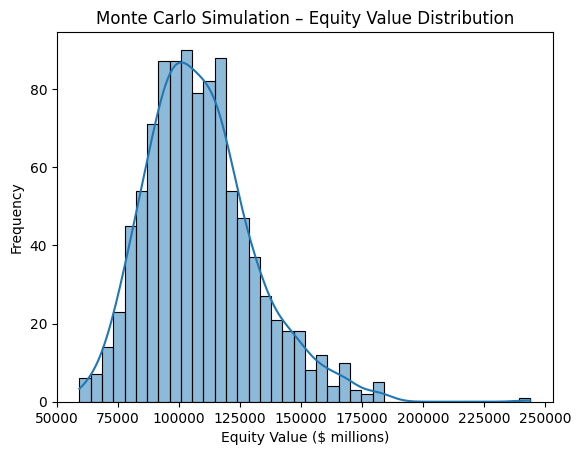

In [8]:
# Step 3: Visualizing the Distribution

import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(sim_df["equity_value"].dropna(), bins=40, kde=True)
plt.title("Monte Carlo Simulation – Equity Value Distribution")
plt.xlabel("Equity Value ($ millions)")
plt.ylabel("Frequency")
plt.show()

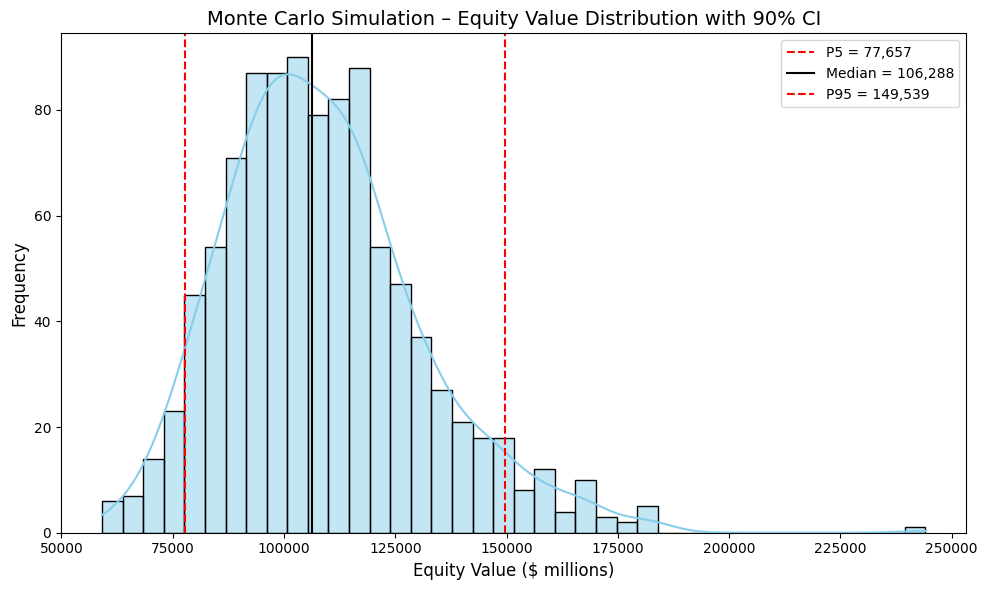

In [16]:
import numpy as np

# Drop NaNs
vals = sim_df["equity_value"].dropna().values

# Compute confidence interval bounds
p5, median, p95 = np.percentile(vals, [5, 50, 95])

# Plot distribution
plt.figure(figsize=(10,6))
sns.histplot(vals, bins=40, kde=True, color="skyblue")

# Add vertical lines for CI and median
plt.axvline(p5, color="red", linestyle="--", label=f"P5 = {p5:,.0f}")
plt.axvline(median, color="black", linestyle="-", label=f"Median = {median:,.0f}")
plt.axvline(p95, color="red", linestyle="--", label=f"P95 = {p95:,.0f}")

# Titles and labels
plt.title("Monte Carlo Simulation – Equity Value Distribution with 90% CI", fontsize=14)
plt.xlabel("Equity Value ($ millions)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

In [22]:
def equity_summary_table(sim_df, col="equity_value"):
    """
    Builds a summary table of equity value distribution from Monte Carlo DCF.
    
    Includes: Mean, Median, 90% CI, 95% CI, and downside tail risk (P5).
    """
    s = pd.to_numeric(sim_df[col], errors="coerce").dropna().values

    mean = np.mean(s)
    median = np.median(s)
    ci90 = (np.percentile(s, 5), np.percentile(s, 95))
    ci95 = (np.percentile(s, 2.5), np.percentile(s, 97.5))
    downside_p5 = np.percentile(s, 5)

    table = pd.DataFrame({
        "Statistic": [
            "Mean",
            "Median",
            "90% CI (P5–P95)",
            "95% CI (P2.5–P97.5)",
            "Downside Risk (P5)"
        ],
        "Value": [
            f"{mean:,.2f}",
            f"{median:,.2f}",
            f"{ci90[0]:,.2f} → {ci90[1]:,.2f}",
            f"{ci95[0]:,.2f} → {ci95[1]:,.2f}",
            f"{downside_p5:,.2f}"
        ],
        "Units": "USD millions"
    })

    return table

# Example usage:
summary_table = equity_summary_table(sim_df, col="equity_value")
print(summary_table.to_string(index=False))

          Statistic                  Value        Units
               Mean             108,812.75 USD millions
             Median             106,288.25 USD millions
    90% CI (P5–P95) 77,656.80 → 149,538.90 USD millions
95% CI (P2.5–P97.5) 72,505.35 → 160,767.77 USD millions
 Downside Risk (P5)              77,656.80 USD millions


In [ ]:
# =============================================================================
#                         THE END 
# =============================================================================